## 1. Data Preparation

### Load data

In [1]:
import pandas as pd

df = pd.read_csv("training_data.csv")

In [2]:
df[:5]

,nodule_name,nodule_category,calcification,internal_structure,lobulation,margin,nodule_type,sphericity,texture,global_seed,slice_thickness,slices_present,file_path
0,Small Cell Lung Cancer (SCLC),Malignant,Absent,Soft Tissue,Nn-Mk,P-Sharp,m4,Lin-Ov,NS-PS,3388.5178,2.00,"[53, 54, 55, 56, 57]",../Demcon_Data/20241221_074106\20241221_074106...
1,Lymphoma,Malignant,Absent,Soft Tissue,N-Marked,Poo-Sh,m7,Ovoid,Part Solid/Mixed,9335.7762,2.00,"[70, 71, 72, 73, 74, 75]",../Demcon_Data/20241221_074106\20241221_074106...
2,Bronchioloalveolar Hyperplasia,Benign,Absent,Soft Tissue,Nn-Mk,Poorly,b6,Linear,NS-PS,9151.7012,2.50,"[26, 27, 28]",../Demcon_Data/20241221_074106\20241221_074106...
3,Carcinoid Tumors,Malignant,Non-Central,Soft Tissue,NaN,P-Sharp,m5,Ov-Ro,Solid,201.8990,2.50,"[51, 52, 53]",../Demcon_Data/20241221_074106\20241221_074106...
4,Intrapulmonary Lymph Nodes,Benign,Absent,Soft Tissue,NaN,Sharp,b7,Ovoid,Solid,8747.3172,1.25,"[23, 24, 25, 26, 27]",../Demcon_Data/20241221_074106\20241221_074106...


In [3]:
print(len(df))

1487


### Remove 34 nodules with missing annotations

In [4]:
print(df.dtypes)

nodule_name            object
nodule_category        object
calcification          object
internal_structure     object
lobulation             object
margin                 object
nodule_type            object
sphericity             object
texture                object
global_seed           float64
slice_thickness       float64
slices_present         object
file_path              object
dtype: object


In [5]:
import ast

df["slices_present"] = df["slices_present"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [6]:
from collections import Counter

length_counts = Counter(len(x) for x in df["slices_present"])
for k in sorted(length_counts):
    print(f"{k} slices: {length_counts[k]} nodules")

0 slices: 34 nodules
1 slices: 18 nodules
2 slices: 239 nodules
3 slices: 376 nodules
4 slices: 196 nodules
5 slices: 163 nodules
6 slices: 142 nodules
7 slices: 123 nodules
8 slices: 88 nodules
9 slices: 50 nodules
10 slices: 15 nodules
11 slices: 16 nodules
12 slices: 6 nodules
13 slices: 12 nodules
14 slices: 7 nodules
18 slices: 1 nodules
19 slices: 1 nodules


In [7]:
df = df[df['slices_present'].apply(lambda x: len(x) > 0)]

In [8]:
print((df['slices_present'].apply(len) == 0).sum())  

0


In [9]:
print(len(df))

1453


### Encoding Labels

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['nodule_name'])

In [11]:
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_map)

{'Active Infection': 0, 'Adenocarcinoma': 1, 'Adenoid Cystic Carcinoma': 2, 'Bronchioloalveolar Hyperplasia': 3, 'Carcinoid Tumors': 4, 'Granuloma': 5, 'Hamartoma': 6, 'Intrapulmonary Lymph Nodes': 7, 'Large Cell (Undifferentiated) Carcinoma': 8, 'Lymphoma': 9, 'Metastatic Tumors': 10, 'Sarcoidosis': 11, 'Sarcomatoid Carcinoma': 12, 'Small Cell Lung Cancer (SCLC)': 13, 'Squamous Cell Carcinoma': 14}


NOTE: Long covid is not part of this study

# 2. Volume input preprocessing

For each sample:

- volume_local: cropped region centered around nodule (based on segmentation)

- volume_context: full slice (resized to something like 256×256), no crop

In [15]:
# Get local crop and global context

import pydicom
import cv2

def slice_local_context(dcm_path_context, dcm_path_local, local_size=(64, 64), context_size=(256, 256)):
    dcm_context = pydicom.dcmread(dcm_path_context)
    img_context = dcm_context.pixel_array

    img_context = img_context.astype(np.float32)
    img_context = (img_context - img_context.min()) / (img_context.max() - img_context.min() + 1e-5)

    dcm_local = pydicom.dcmread(dcm_path_local)
    img_local = dcm_local.pixel_array

    img_local = img_local.astype(np.float32)
    img_local = (img_local - img_local.min()) / (img_local.max() - img_local.min() + 1e-5)

    # Pad if needed
    cropped_local = cv2.resize(img_local, local_size)

    # Resize whole slice for context
    resized_context = cv2.resize(img_context, context_size)

    return cropped_local, resized_context

In [ ]:
# Trying with 1 data sample

import os

from pathlib import Path

# Go up two folders from current script
root = Path.cwd().parents[1]

json_path = df.iloc[0]['file_path']
print(json_path)
parts = os.path.normpath(json_path).split(os.sep)
folder = parts[2]  # '20241221_074106'
ScanID = parts[5]  # 'LIDC-IDRI-0001'
sliceAmount = len(df.iloc[0]['slices_present'])


local_slices = []
context_slices = []

for slice in range(0,sliceAmount):
    dcm_path_context = root / "segmented" / str(folder) / "lungs" / str(ScanID) / f"{slice}.dcm"# change if path is different
    dcm_path_local = root / "segmented" / str(folder) / "nodules" / str(ScanID) / f"{slice}.dcm"# change if path is different
    local, context = slice_local_context(
        dcm_path_context, dcm_path_local,
        local_size=(64, 64),
        context_size=(256, 256)
    )
    local_slices.append(local)
    context_slices.append(context)

../Demcon_Data/20241221_074106\20241221_074106\LIDC-IDRI\LIDC-IDRI-0000\01-01-2000-NA-NA-02587\3976134.000000-NA-94964\segmentation_00000.json


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.510917  , 0.66812223, 0.78165936, 0.59825325,
       0.57205236, 0.742358  , 0.9956331 , 0.87336236, 0.72052395,
       0.49781656, 0.4803493 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

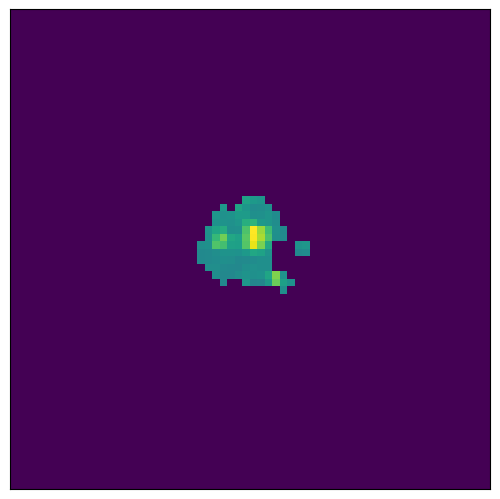

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.imshow(local_slices[0])
#plt.title("Extracted Region from DICOM")
ax.set_xticks([])
ax.set_yticks([])
ax.set_position([0, 0, 1, 1])

local_slices[0][30]

In [18]:
# Pads or crops a list of 2D slices to a fixed 3D volume.
import numpy as np
def pad_or_crop_volume(slices, target_depth, shape):
    D = len(slices)
    h, w = shape

    if D == 0:
        return np.zeros((1, target_depth, h, w), dtype=np.float32)

    volume = np.stack(slices, axis=0)

    if D < target_depth:
        pad_before = (target_depth - D) // 2
        pad_after = target_depth - D - pad_before
        volume = np.pad(volume, ((pad_before, pad_after), (0, 0), (0, 0)), mode='constant')
    elif D > target_depth:
        start = (D - target_depth) // 2
        volume = volume[start:start+target_depth]

    return volume[None, ...]  # Add channel dim: [1, D, H, W]


In [19]:
volume_local = pad_or_crop_volume(local_slices, target_depth=5, shape=(64, 64))
volume_context = pad_or_crop_volume(context_slices, target_depth=7, shape=(256, 256))

print("volume_local shape:", volume_local.shape)
print("volume_context shape:", volume_context.shape)

volume_local shape: (1, 5, 64, 64)
volume_context shape: (1, 7, 256, 256)


In [ ]:
# Applying to entire dataset

from tqdm import tqdm

all_locals = []
all_contexts = []
all_labels = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing samples"):
    try:
        json_path = row['file_path']
        label = row['label']
        parts = os.path.normpath(json_path).split(os.sep)
        folder = parts[2]  # '20241221_074106'
        ScanID = parts[5]  # 'LIDC-IDRI-0001'
        sliceAmount = len(row['slices_present'])


        local_slices = []
        context_slices = []

        for slice in range(0,sliceAmount):
            dcm_path_context = root / "segmented" / str(folder) / "lungs" / str(ScanID) / f"{slice}.dcm"# change if path is different
            dcm_path_local = root / "segmented" / str(folder) / "nodules" / str(ScanID) / f"{slice}.dcm"# change if path is different
            local, context = slice_local_context(
                dcm_path_context, dcm_path_local,
                local_size=(64, 64),
                context_size=(256, 256)
            )
            local_slices.append(local)
            context_slices.append(context)

        volume_local = pad_or_crop_volume(local_slices, target_depth=5, shape=(64, 64))
        volume_context = pad_or_crop_volume(context_slices, target_depth=7, shape=(256, 256))

        all_locals.append(volume_local)
        all_contexts.append(volume_context)
        all_labels.append(label)

    except Exception as e:
        print(f"Skipping row due to error: {e}")


Processing samples: 100%|██████████| 1453/1453 [00:28<00:00, 50.39it/s]


# 3. Radiomics preparation

In [21]:
radiomics_columns = [
    "calcification", "internal_structure", "lobulation",
    "margin", "sphericity", "texture"
]

In [22]:
radiomics_df = df[radiomics_columns].copy()

In [23]:
radiomics_encoded = pd.get_dummies(radiomics_df, drop_first=False)

In [24]:
print("Radiomics vector shape:", radiomics_encoded.shape)
radiomics_encoded.head()

Radiomics vector shape: (1453, 25)


,calcification_Absent,calcification_Central,calcification_Laminated,calcification_Non-Central,calcification_Popcorn,calcification_Solid,internal_structure_Soft Tissue,lobulation_Marked,lobulation_N-Marked,lobulation_Nn-Mk,...,margin_Sharp,sphericity_Lin-Ov,sphericity_Linear,sphericity_Ov-Ro,sphericity_Ovoid,sphericity_Round,texture_NS-PS,texture_PS-Solid,texture_Part Solid/Mixed,texture_Solid
0,True,False,False,False,False,False,True,False,False,True,...,False,True,False,False,False,False,True,False,False,False
1,True,False,False,False,False,False,True,False,True,False,...,False,False,False,False,True,False,False,False,True,False
2,True,False,False,False,False,False,True,False,False,True,...,False,False,True,False,False,False,True,False,False,False
3,False,False,False,True,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4,True,False,False,False,False,False,True,False,False,False,...,True,False,False,False,True,False,False,False,False,True


In [25]:
X_radiomics = radiomics_encoded.to_numpy(dtype=np.float32)

In [26]:
X_radiomics.shape

(1453, 25)

# 4. Create Pytorch Dataset

In [27]:
import torch
from torch.utils.data import Dataset

In [28]:
class TripleFusionDataset(Dataset):
    def __init__(self, all_locals, all_contexts, X_radiomics, labels_df):
        self.all_locals = all_locals
        self.all_contexts = all_contexts
        self.radiomics = X_radiomics
        self.labels = labels_df["label"].to_numpy()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {
            "volume_local": torch.tensor(self.all_locals[idx], dtype=torch.float32),
            "volume_context": torch.tensor(self.all_contexts[idx], dtype=torch.float32),
            "radiomics": torch.tensor(self.radiomics[idx], dtype=torch.float32),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }
        return sample


In [29]:
dataset = TripleFusionDataset(
    all_locals=all_locals,
    all_contexts=all_contexts,
    X_radiomics=X_radiomics,
    labels_df=df  
)

# 5. Triple Fusion Architecture


| Branch           | Input Shape           | Type     |
|------------------|------------------------|----------|
| `volume_local`   | `[B, 1, 5, 64, 64]`     | 3D CNN   |
| `volume_context` | `[B, 1, 7, 256, 256]`   | 3D CNN   |
| `radiomics`      | `[B, 25]`               | MLP      |


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Local Branch

In [31]:
class SEBlock3D(nn.Module):
    def __init__(self, channels, reduction=8):  # try reduction=8 instead of 16
        super().__init__()
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc   = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y  # broadcasting

class ResidualSEBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, drop_rate=0.2):
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm3d(out_ch)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm3d(out_ch)
        self.se    = SEBlock3D(out_ch, reduction=8)
        self.drop  = nn.Dropout3d(p=drop_rate)

        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_ch)
            )
        else:
            self.downsample = nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out = out + identity
        out = self.drop(out)       # dropout after addition
        return self.relu(out)

class LocalBranch(nn.Module):
    def __init__(self):
        super().__init__()
        # WIDER stem: 1→32 channels
        self.stem = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2)  # D→D/2, H→H/2, W→W/2
        )
        # DEPTH: add two more blocks, channels doubling each time
        self.resblock1 = ResidualSEBlock(16, 32, stride=2)   # D/2→D/4
        self.resblock2 = ResidualSEBlock(32, 64, stride=2)  # D/4→D/8
        self.resblock3 = ResidualSEBlock(64, 64, stride=1) # D/8→D/8
        self.pool      = nn.AdaptiveAvgPool3d((1,1,1))       # → [B,128,1,1,1]

    def forward(self, x):
        x = self.stem(x)      # [B, 32, D/2, H/2, W/2]
        x = self.resblock1(x) # [B, 64, D/4, H/4, W/4]
        x = self.resblock2(x) # [B, 128, D/8, H/8, W/8]
        x = self.resblock3(x) # [B, 128, D/8, H/8, W/8]
        x = self.pool(x)      # [B, 128, 1,1,1]
        return x.view(x.size(0), -1)  # [B, 128]


### Context Branch

In [67]:
class ContextBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1, bias=False),  # 1→32
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),           # (D,H,W)→(D/2,H/2,W/2)

            nn.Conv3d(32, 64, kernel_size=3, padding=1, bias=False), # 32→64
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),           # (D/2→D/4, H/2→H/4, W/2→W/4)

            nn.AdaptiveAvgPool3d((1,1,1))  # → [B, 64,1,1,1]
        )

    def forward(self, x):
        x = self.conv(x)
        return x.view(x.size(0), -1)  # [B, 64]

### Radiomics Branch

In [68]:
class RadiomicsBranch(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),      # LayerNorm can be more stable for small batches
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32)
        )
    def forward(self, x):
        return self.fc(x)  # [B,32]

In [69]:
class AttentionFusion(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Tanh(),
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        weights = self.attn(x)
        return x * weights  # Element-wise attention

### Fusion Model

In [70]:
class TripleFusionModel(nn.Module):
    def __init__(self, num_classes, radiomics_dim=25):
        super().__init__()
        self.local_branch     = LocalBranch()           # output: [B,128]
        self.context_branch   = ContextBranch()         # output: [B,64]
        self.radiomics_branch = RadiomicsBranch(radiomics_dim)  # [B,32]

        fused_dim = 64 + 64 + 32  # = 224
        self.attn_fusion = AttentionFusion(fused_dim)

        # balance the local features with a learnable scalar
        self.alpha = nn.Parameter(torch.tensor(1.0))

        self.classifier = nn.Sequential(
            nn.Linear(fused_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, volume_local, volume_context, radiomics):
        local_feat = self.local_branch(volume_local)         # [B,128]
        context_feat = self.context_branch(volume_context)   # [B,64]
        radio_feat = self.radiomics_branch(radiomics)        # [B,32]

        # scale local by alpha, then concatenate all three
        fused = torch.cat([self.alpha * local_feat, context_feat, radio_feat], dim=1)  # [B,224]
        fused_attn = self.attn_fusion(fused)  # [B,224], each feature reweighted
        out = self.classifier(fused_attn)     # [B,num_classes]
        return out

# 6. Training

In [71]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, reduction='none')  # shape [B]
        pt = torch.exp(-ce)  # pt = softmax probability of the true class
        if self.alpha is not None:
            at = self.alpha.gather(0, targets)  # shape [B]
            loss = at * (1 - pt) ** self.gamma * ce
        else:
            loss = (1 - pt) ** self.gamma * ce
        return loss.mean() if self.reduction=='mean' else loss.sum()

In [72]:
import torch.optim as optim

num_classes = len(df["label"].unique())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_counts = df["label"].value_counts().sort_index()
weights = 1.0 / class_counts
weights = weights / weights.sum()
weights_tensor = torch.tensor(weights.values, dtype=torch.float32).to(device)

criterion = FocalLoss(gamma=2, alpha=weights_tensor, reduction='mean')
model = TripleFusionModel(num_classes=num_classes, radiomics_dim=25)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1.2e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

In [73]:
def compute_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

In [74]:
from tqdm import tqdm
import time

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_acc = 0.0

    pbar = tqdm(dataloader, desc="Training", leave=False)

    for batch in pbar:
        start_time = time.time()

        vol_local = batch["volume_local"].to(device)
        vol_context = batch["volume_context"].to(device)
        radiomics = batch["radiomics"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(vol_local, vol_context, radiomics)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        acc = compute_accuracy(outputs, labels)
        batch_time = time.time() - start_time

        total_loss += loss.item()
        total_acc += acc

        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{acc:.4f}",
            "time": f"{batch_time:.2f}s"
        })

    return total_loss / len(dataloader), total_acc / len(dataloader)


In [75]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    pbar = tqdm(dataloader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in pbar:
            vol_local = batch["volume_local"].to(device)
            vol_context = batch["volume_context"].to(device)
            radiomics = batch["radiomics"].to(device)
            labels = batch["label"].to(device)

            outputs = model(vol_local, vol_context, radiomics)
            loss = criterion(outputs, labels)
            acc = compute_accuracy(outputs, labels)

            total_loss += loss.item()
            total_acc += acc

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{acc:.4f}"
            })

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [41]:
from torch.utils.data import random_split, DataLoader
# Initial fixed split: 10% test, 90% train+val
total_size = len(dataset)
test_size = int(0.1 * total_size)
train_val_size = total_size - test_size

# Split test set first and keep it fixed
train_val_set, test_set = random_split(dataset, [train_val_size, test_size])
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

def create_train_val_loaders(train_val_set, batch_size=8):
    """Shuffles and splits train_val_set into new train/val sets."""
    val_ratio = 0.1
    train_val_len = len(train_val_set)
    val_size = int(val_ratio * train_val_len)
    train_size = train_val_len - val_size
    train_set, val_set = random_split(train_val_set, [train_size, val_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [42]:
batch_size = 8
# Create initial train/val splits
train_loader, val_loader = create_train_val_loaders(train_val_set, batch_size)

In [ ]:
num_epochs = 35

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc     = validate(model, val_loader, criterion, device)

    scheduler.step()
    current_lr = scheduler.optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print(f"  LR: {current_lr:.5f}")

Epoch 1/10
  Train Loss: 0.0154 | Train Acc: 0.7897
  Val   Loss: 0.0537 | Val   Acc: 0.6324
  LR: 0.00022


Epoch 2/10
  Train Loss: 0.0141 | Train Acc: 0.7846
  Val   Loss: 0.0561 | Val   Acc: 0.6324
  LR: 0.00019


Epoch 3/10
  Train Loss: 0.0129 | Train Acc: 0.8159
  Val   Loss: 0.0560 | Val   Acc: 0.6324
  LR: 0.00016


Epoch 4/10
  Train Loss: 0.0145 | Train Acc: 0.8091
  Val   Loss: 0.0542 | Val   Acc: 0.6618
  LR: 0.00014


Epoch 5/10
  Train Loss: 0.0136 | Train Acc: 0.7973
  Val   Loss: 0.0547 | Val   Acc: 0.6618
  LR: 0.00011


Epoch 6/10
  Train Loss: 0.0126 | Train Acc: 0.8108
  Val   Loss: 0.0572 | Val   Acc: 0.6397
  LR: 0.00009


Epoch 7/10
  Train Loss: 0.0121 | Train Acc: 0.8176
  Val   Loss: 0.0575 | Val   Acc: 0.6471
  LR: 0.00007


Epoch 8/10
  Train Loss: 0.0123 | Train Acc: 0.8252
  Val   Loss: 0.0574 | Val   Acc: 0.6618
  LR: 0.00006


Epoch 9/10
  Train Loss: 0.0122 | Train Acc: 0.8142
  Val   Loss: 0.0590 | Val   Acc: 0.6397
  LR: 0.00004


Epoch 10/10
  Train Loss: 0.0114 | Train Acc: 0.8353
  Val   Loss: 0.0567 | Val   Acc: 0.6618
  LR: 0.00003


# 7. Evaluation

NOTE: I forgot to do a test dataset split so I'm currently gonna get a random subset

In [82]:
import torch.nn.functional as F

def predict(model, dataloader, device):
    model.eval()
    topk_preds = [[] for _ in range(5)]
    topk_probs = [[] for _ in range(5)]
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            vol_local   = batch["volume_local"].to(device)
            vol_context = batch["volume_context"].to(device)
            radiomics   = batch["radiomics"].to(device)
            labels      = batch["label"].to(device)

            outputs = model(vol_local, vol_context, radiomics)
            probs = F.softmax(outputs, dim=1)
            top5 = torch.topk(probs, k=5, dim=1)

            for i in range(5):
                topk_preds[i].extend(top5.indices[:, i].cpu().numpy())
                topk_probs[i].extend(top5.values[:, i].cpu().numpy())

            all_labels.extend(labels.cpu().numpy())

    return {
        "top1_preds": np.array(topk_preds[0]),
        "top2_preds": np.array(topk_preds[1]),
        "top3_preds": np.array(topk_preds[2]),
        "top4_preds": np.array(topk_preds[3]),
        "top5_preds": np.array(topk_preds[4]),
        "top1_probs": np.array(topk_probs[0]),
        "top2_probs": np.array(topk_probs[1]),
        "top3_probs": np.array(topk_probs[2]),
        "top4_probs": np.array(topk_probs[3]),
        "top5_probs": np.array(topk_probs[4]),
        "labels":     np.array(all_labels)
    }


In [83]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device, class_names):
    results = predict(model, dataloader, device)

    top1 = results["top1_preds"]
    top2 = results["top2_preds"]
    top3 = results["top3_preds"]
    top4 = results["top4_preds"]
    top5 = results["top5_preds"]
    probs1 = results["top1_probs"]
    probs2 = results["top2_probs"]
    probs3 = results["top3_probs"]
    probs4 = results["top4_probs"]
    probs5 = results["top5_probs"]
    y_true = results["labels"]

    # Top-1 metrics
    acc1 = accuracy_score(y_true, top1)
    f1_1 = f1_score(y_true, top1, average="weighted")
    print(f"Top-1 Accuracy: {acc1:.4f}")
    print(f"Top-1 F1 Score:  {f1_1:.4f}")

    # Top-2 accuracy
    top2_correct = ((top1 == y_true) | (top2 == y_true)).astype(int)
    acc2 = top2_correct.mean()
    print(f"Top-2 Accuracy: {acc2:.4f}")

    # Top-3 accuracy
    top3_correct = ((top1 == y_true) | (top2 == y_true) | (top3 == y_true)).astype(int)
    acc3 = top3_correct.mean()
    print(f"Top-3 Accuracy: {acc3:.4f}\n")

    # Classification report
    print("Classification Report (Top-1):")
    print(classification_report(y_true, top1, target_names=class_names))

    # Example predictions
    print("\nSample Predictions with Confidence:")
    for i in range(5):
        print(f"True: {class_names[y_true[i]]}, "
              f"Top-1: {class_names[top1[i]]} ({probs1[i]*100:.1f}%), "
              f"Top-2: {class_names[top2[i]]} ({probs2[i]*100:.1f}%), "
              f"Top-3: {class_names[top3[i]]} ({probs3[i]*100:.1f}%)")
        
        p3sum = probs1[i] + probs2[i] + probs3[i]
        if p3sum < 0.75:
            print(f", Top-4: {class_names[top4[i]]} ({probs4[i]*100:.1f}%)", end='')
            p4sum = p3sum + probs4[i]
            if p4sum < 0.85:
                print(f", Top-5: {class_names[top5[i]]} ({probs5[i]*100:.1f}%)", end='')
        print()  # Newline after each sample

    # Confusion Matrix (Top-1)
    cm = confusion_matrix(y_true, top1)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted (Top-1)")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Top-1)")
    plt.show()


Top-1 Accuracy: 0.5517
Top-1 F1 Score:  0.5471
Top-2 Accuracy: 0.7448
Top-3 Accuracy: 0.8552

Classification Report (Top-1):
                                         precision    recall  f1-score   support

                       Active Infection       0.55      0.75      0.63         8
                         Adenocarcinoma       0.33      0.67      0.44         6
               Adenoid Cystic Carcinoma       0.75      0.21      0.33        14
         Bronchioloalveolar Hyperplasia       0.78      0.61      0.68        23
                       Carcinoid Tumors       0.75      0.75      0.75         4
                              Granuloma       0.71      0.62      0.67         8
                              Hamartoma       1.00      1.00      1.00         9
             Intrapulmonary Lymph Nodes       1.00      0.57      0.73         7
Large Cell (Undifferentiated) Carcinoma       0.30      0.27      0.29        11
                               Lymphoma       0.33      0.57    

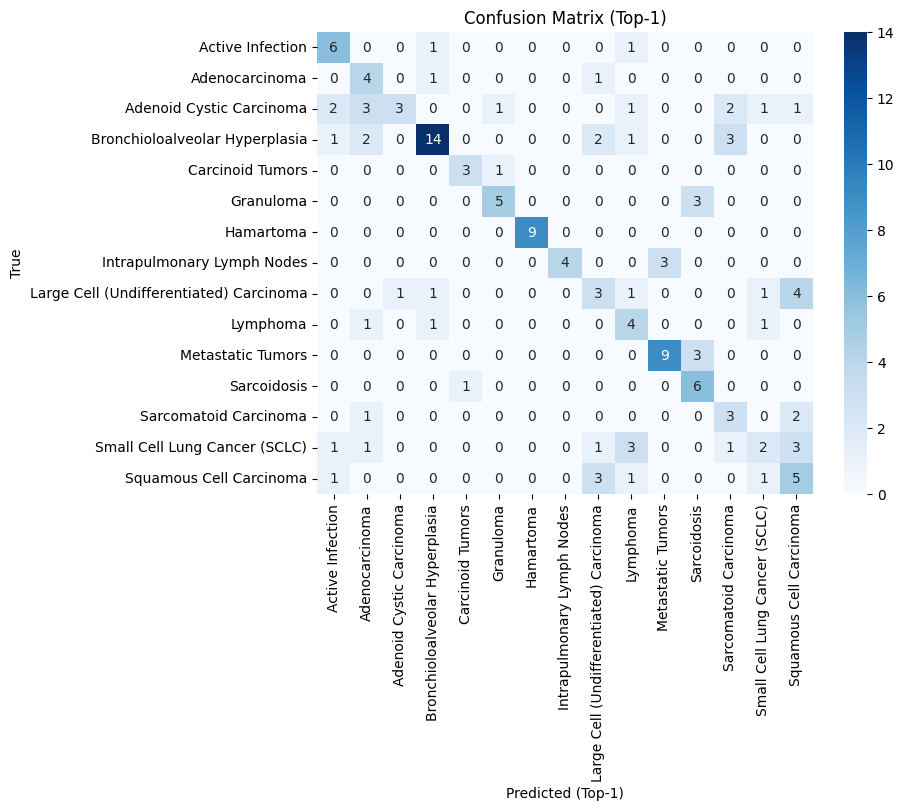

In [84]:
class_names = list(le.classes_)
evaluate_model(model, test_loader, device, class_names)

# 8. Explainability

### Grad-Cam

In [47]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [48]:
target_layer = model.context_branch.conv[4]  # the second Conv3D layer

In [49]:
cam = GradCAM(model=model.context_branch, target_layers=[target_layer])

batch = next(iter(test_loader))  # one batch
input_tensor = batch["volume_context"][4].unsqueeze(0).to(device)  # [1, 1, D, H, W]
target_category = batch["label"][4].item()

grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_category)])


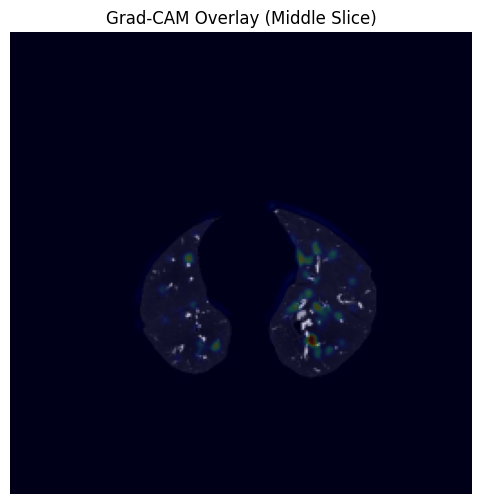

In [50]:
# Visualize the heatmap 

input_volume = batch["volume_context"][4].squeeze(0).cpu().numpy() 

def normalize(x):
    x = x - x.min()
    x = x / (x.max() + 1e-5)
    return x

volume = batch["volume_context"][4].squeeze(0).cpu().numpy()      
grayscale = grayscale_cam[0]                                    

# Take the middle slice
mid = volume.shape[0] // 2
slice_img = normalize(volume[mid])
cam_slice = normalize(grayscale[mid])

if cam_slice.shape != slice_img.shape:
    cam_slice = cv2.resize(cam_slice, slice_img.shape[::-1])

# Convert CAM to heatmap
cam_uint8 = np.ascontiguousarray((cam_slice * 255).astype(np.uint8))
heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

# Prepare grayscale CT image
ct_rgb = np.stack([slice_img] * 3, axis=-1)

overlay = 0.8 * ct_rgb + 0.2 * heatmap

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title("Grad-CAM Overlay (Middle Slice)")
plt.axis("off")
plt.show()

# 9. Save model

In [80]:
torch.save(model.state_dict(), "triple_fusion_model_altdifflossv2.pkl")

In [52]:
#torch.save(model.state_dict(), "triple_fusion_model.pkl")